In [1]:
# imports
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn
import os
import string
from PIL import Image

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Create a mapping from the image files to the character they represents
character_list = list(string.digits + string.ascii_uppercase + string.ascii_lowercase)
nums = range(1,len(character_list)+1)
file_to_character = dict(zip(nums, character_list))

In [10]:
# Take the median size of the images as the standard_size for 
# normalization of the images
path = '/home/reza/MachineLearning/Hand-Writing-Recognition/data/English/img/'
img_sizes = []
for folder in os.listdir(path):
    for img_file in os.listdir(path+'/'+folder+'/'):
        img = Image.open(path+'/'+folder+'/'+img_file)
        img_sizes.append(img.size)

# resize function only takes int values
STANDARD_SIZE = map(int, median(img_sizes, axis=0))

In [6]:
# Create an image class that allows us to represent the image in matrix or vector from
class img():
    def __init__(self, img_file=None, img_path=None):
        if img_file is None or img_path is None:
            raise Exception('Must give an image file as input along'
                            'with its file name')
        self.img_matrix = None
        self.img_vector = None
        self.img_label = None
        self.img_file = img_file
        self.img_path = img_path
        
    def img_to_matrix(self):
        """
        Extract a matrix representation of the image
        """
        # Resize the image to a standard size
        img_resized = self.img_file.resize(STANDARD_SIZE)
        self.img_matrix = array(img_resized)

    def flatten_image(self):
        """
        Flatten the matrix representation of the image. If the
        matrix has shape (m, n) then the vector representation
        has shape (1, m * n)
        """
        if self.img_matrix is None:
            self.img_to_matrix()
        s = self.img_matrix.shape[0] * self.img_matrix.shape[1]
        self.img_vector = self.img_matrix.reshape(1, s)[0]

    def get_img_label(self):
        """"
        Sets the label for the image file, i.e, the English
        character the image is showing
        """
        file_name = self.img_path.split('/')[-1][3:6]
        self.img_label = file_to_character[int(file_name)]
        
# img1 = img(img_file=img_file, img_path='blahblah/im-001')
# img1.img_label
# img1.img_to_matrix()
# print img1.img_matrix
# img1.flatten_image()
# img1.img_vector
# img1.get_img_label()
# img1.img_label


In [7]:
# Gather features of the image for building the training data
path = '/home/reza/MachineLearning/Hand-Writing-Recognition/data/English/img/'
data = []
labels = []
for folder in os.listdir(path):
    for img_file in os.listdir(path+'/'+folder+'/'):
        img_file = Image.open(path+'/'+folder+'/'+img_file)
        img_path = img_file.filename
        img_file = img_file.convert('L')
        
        # Open in the image file
#         img_file = img_file.convert("L").filter(ImageFilter.GaussianBlur(radius = 2))
        curr_img = img(img_file=img_file, img_path=img_path)
        
        # Take a vectore representation of the image
        curr_img.flatten_image()
        data.append(curr_img.img_vector)
        
        # add the label
        curr_img.get_img_label()
        labels.append(curr_img.img_label)

data = np.array(data)

In [8]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn import svm

# Create the training data
pca = PCA(n_components=50)
X = pca.fit_transform(data)
df = DataFrame(X)
response = 'label'
df[response] = labels

# Divide data to test and train
mask = np.random.rand(len(df)) < 0.85
train_dat = df[mask]
test_dat = df[~mask]
y_test = np.array(test_dat[response])
test_dat.drop(response, axis=1, inplace=True)


/home/reza/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
# Run random forest on the train model and pick the number
# of trees used for the model
rf = RandomForestClassifier(n_estimators=1000, oob_score=True)
rf.fit(train_dat.drop(response, axis=1), train_dat[response])
prediction = rf.predict(test_dat)

# Check error percentage on the test set and tune parameters
mean(prediction != y_test)

0.42517605633802819

In [124]:
# Lets test this on a sample image
path = '/home/reza/Downloads/test.jpg'
img_file = Image.open(path)
img_path = img_file.filename
img_file = img_file.convert('L')
        
# Open in the image file
img_file = img_file.convert("L").filter(ImageFilter.GaussianBlur(radius = 2))
curr_img = img(img_file=img_file, img_path=img_path)
        
# Take a vectore representation of the image
curr_img.flatten_image()
test_point = pca.transform(curr_img.img_vector)

# Predict the label for the test point
rf.predict(test_point)

array(['N'], dtype=object)

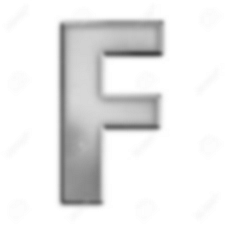

In [55]:
from PIL import ImageFilter
img_file.filter(ImageFilter.SHARPEN)


## Using a different Dataset for Handwriting Recognition

In [33]:
# Read the symbols in the data
path = '/home/reza/MachineLearning/Hand-Writing-Recognition/data/coordinate/'
symbols = pd.read_csv(path+'symbols.csv', error_bad_lines=False, delimiter=';')

# Create a mapping from the symbol to the character it represents
id_to_char = dict(zip(symbols.symbol_id.astype(str), symbols.latex))

In [50]:
import csv
import json

# Create a dictionary with keys alphanumeric characters
# and values strokes. Each stroc consists of a set of 
# (x,y,t) coordinates
recordings = dict()
with open(path+'train-data.csv', 'rb') as csvfile:
    data = csv.reader(csvfile, delimiter=';')
    next(data, None)
    for row in data:
        symbol = id_to_char[row[0]]
        if symbol.isalnum():
            recordings[symbol] = json.loads(row[2])

In [39]:
# Some configuration needed for modifying the drawing record
FACTOR_CORRECTION = 0.00001
DEHOOK_THRESHOLD = 3
DEHOOK_ANGLE_THRESHOLD = 90

In [51]:
# Create a class drawing_record that has methods to
# handle each record (scaling, resampling, feature extraction)
class drawing_record():
    def  __init__(self, record):
        self.coordinates = record
    def find_bounding_box(self):
        """
        Find the bounding box of the drawing character
        """
        mint, minx, miny = [float('inf')]*3
        maxx, maxy, maxt = [float('-inf')]*3
        for stroke in self.coordinates:
            for point in stroke:
                if point['time'] < mint:
                    mint = point['time']
                if point['x'] < minx:
                    minx = point['x']
                if point['y'] < miny:
                    miny = point['y']
                if point['x'] > maxx:
                    maxx = point['x']
                if point['y'] > maxy:
                    maxy = point['y']
        return (mint, minx, maxx, miny, maxy)

    def dehook(self):
        """
        Removes hooks at the begining or end of a stroke
        """
        # Given three points p0,p1,p2 in order, it calculates
        # the angle between p_10 and p_21
        def calculate_angle(points):
            # Return euclidean distance between two points
            def diff(v,w):
                v = np.array([v['x'], v['y']])
                w = np.array([w['x'], w['y']])
                return v-w
            p_10 = diff(points[0], points[1])
            p_21 = diff(points[1], points[2])
            cos_angle = float(p_10.dot(p_21))/(sqrt(p_10.dot(p_10)) * sqrt(p_21.dot(p_21)))
            angle = arccos(cos_angle) * 180/pi
            return angle
        def dehook_stroke(stroke, angle):
            new_stroke = stroke[:-1] # everything but the last point
            p = stroke[-1] # last point
            stroke = stroke[-3:] # last three points
            if calculate_angle(stroke) < angle:
                new_stroke.append(p)
                print calculate_angle(stroke)
                return new_stroke
            else:
                dehook_stroke(new_stroke, angle)
                print calculate_angle(stroke)
        if len(self.coordinates) < DEHOOK_THRESHOLD:
            return
        for i, stroke in enumerate(self.coordinates):
            self.coordinates[i] = dehook_stroke(stroke, DEHOOK_ANGLE_THRESHOLD)
            
    
    def scale_shift(self):
        """
        Scale and shif the coordinates of the drawing.
        Only the smaller dimension gets centered
        """
        mint, minx, maxx, miny, maxy = self.find_bounding_box()
        for stroke in self.coordinates:
            for point in stroke:
                width = (maxx-minx) + FACTOR_CORRECTION
                height = (maxy-miny) + FACTOR_CORRECTION
                fx = 1.0/width
                fy = 1.0/height
                f = min(fx,fy)
                add = min(width, height)/2.0 * f
                addx, addy = 0, 0
                if f == fx:
                    addx = add
                else:
                    addy = add
                point['x'] = (point['x'] - minx) * f - addx
                point['y'] = (point['y'] - miny) * f - addy
                point['time'] = point['time'] - mint

    def resample(self):
        pass
    
dr = drawing_record(recordings['l'])
# print dr.find_bounding_box()
# dr.scale_shift()
dr.dehook()
dr.coordinates

0.0
0.0
90.0
0.0
0.0


[[{u'time': 1418737792540, u'x': 582, u'y': 562},
  {u'time': 1418737792546, u'x': 582, u'y': 563},
  {u'time': 1418737792554, u'x': 582, u'y': 567},
  {u'time': 1418737792562, u'x': 580, u'y': 572},
  {u'time': 1418737792570, u'x': 580, u'y': 579},
  {u'time': 1418737792578, u'x': 580, u'y': 586},
  {u'time': 1418737792586, u'x': 580, u'y': 593},
  {u'time': 1418737792592, u'x': 580, u'y': 600},
  {u'time': 1418737792600, u'x': 578, u'y': 607},
  {u'time': 1418737792608, u'x': 576, u'y': 616},
  {u'time': 1418737792616, u'x': 576, u'y': 625},
  {u'time': 1418737792624, u'x': 576, u'y': 634},
  {u'time': 1418737792632, u'x': 576, u'y': 643},
  {u'time': 1418737792640, u'x': 574, u'y': 652},
  {u'time': 1418737792648, u'x': 574, u'y': 661},
  {u'time': 1418737792656, u'x': 574, u'y': 670},
  {u'time': 1418737792664, u'x': 574, u'y': 679},
  {u'time': 1418737792670, u'x': 572, u'y': 688},
  {u'time': 1418737792678, u'x': 572, u'y': 697},
  {u'time': 1418737792686, u'x': 570, u'y': 704},


In [7]:
for key, val in recordings.items():
    if len(val) > 2:
        print key, len(val)
    

A 3
E 3
F 3
H 3
K 3
k 3
l 4
